# Modelo m3: regressão lasso com acoplamentos não-lineares

Nesse modelo, $A=A(y,U_r)$ e $\varepsilon=\varepsilon(U_r$). Além disso, há um acoplamento $B$ proporcional a velocidade $\dot{y}$.

Os coeficiente $A$ e $B$ são dados por

$$A=A(y, U_r)=A_0 + A_1|y| + A_2|y|^2 + A_3|y|^3$$

e

$$B=B(y, U_r)=B_0 + B_1|y| + B_2|y|^2 + B_3|y|^3$$

Onde os coeficientes $A_i$ e $B_i$ são funções de $U_r$.

A equação do oscilador wake é

$$\ddot{q} + \varepsilon (St U_r)(q^2-1)\dot{q} + (St U_r)^2q = A\ddot{y} + B\dot{y}$$

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Dissertação Caio

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Dissertação Caio


In [ ]:
import numpy as np
from sklearn import linear_model
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'

from parametros_OM import Xi_y, m_o, Ca_pot, q_hat, C_dv, C_0l, St, c

n_train = 25
n_parts = 4

In [ ]:
def polynomial(u, *coefficients):
    return sum(coef * u**i for i, coef in enumerate(coefficients[::-1]))

def polynomial_piecewise(u, coefficients, lower_limits, upper_limits):
    for i in len(coefficients):
        if u>lower_limits[i] and u<upper_limits[i]:
            return polynomial(u, *coefficients[i])

def fit_train_samples(U, A0, A1, A2, A3, B0, B1, B2, B3, eps, train_indices, degreeA=4, degreeEps=4):
    coeff_A0, _ = curve_fit(lambda u, *coeff: polynomial(u, *coeff),
                         U[train_indices], A0[train_indices],
                         p0=[1]*(degreeA+1))


    coeff_A1, _ = curve_fit(lambda u, *coeff: polynomial(u, *coeff),
                         U[train_indices], A1[train_indices],
                         p0=[1]*(degreeA+1))


    coeff_A2, _ = curve_fit(lambda u, *coeff: polynomial(u, *coeff),
                         U[train_indices], A2[train_indices],
                         p0=[1]*(degreeA+1))


    coeff_A3, _ = curve_fit(lambda u, *coeff: polynomial(u, *coeff),
                         U[train_indices], A3[train_indices],
                         p0=[1]*(degreeA+1))


    coeff_B0, _ = curve_fit(lambda u, *coeff: polynomial(u, *coeff),
                         U[train_indices], B0[train_indices],
                         p0=[1]*(degreeA+1))


    coeff_B1, _ = curve_fit(lambda u, *coeff: polynomial(u, *coeff),
                         U[train_indices], B1[train_indices],
                         p0=[1]*(degreeA+1))


    coeff_B2, _ = curve_fit(lambda u, *coeff: polynomial(u, *coeff),
                         U[train_indices], B2[train_indices],
                         p0=[1]*(degreeA+1))


    coeff_B3, _ = curve_fit(lambda u, *coeff: polynomial(u, *coeff),
                         U[train_indices], B3[train_indices],
                         p0=[1]*(degreeA+1))


    coeff_eps, _ = curve_fit(lambda u, *coeff: polynomial(u, *coeff),
                           U[train_indices], eps[train_indices],
                           p0=[1]*(degreeEps+1))

    return {
        'coefficients_A0': coeff_A0,
        'coefficients_A1': coeff_A1,
        'coefficients_A2': coeff_A2,
        'coefficients_A3': coeff_A3,
        'coefficients_B0': coeff_B0,
        'coefficients_B1': coeff_B1,
        'coefficients_B2': coeff_B2,
        'coefficients_B3': coeff_B3,
        'coefficients_eps': coeff_eps,
    }

def om_system(x, eps, A0, A1, A2, A3, B0, B1, B2, B3, Ur):
    q, q_pd, y, y_pd = x
    S = St * Ur
    term1 = (Ur**2 / (2 * np.pi**3 * (m_o + Ca_pot)))
    term2 = (c * q - 2 * np.pi * C_dv * y_pd / Ur) * np.sqrt(1 + (2 * np.pi * y_pd / Ur)**2)
    y_sd = term1 * term2 - 2 * Xi_y * y_pd - y
    q_sd = - eps * S * (q**2 - 1) * q_pd - S**2 * q + y_sd * (A0 + A1*np.abs(y) + A2*np.abs(y)**2 + A3*np.abs(y)**3)
    + y_pd * (B0 + B1*np.abs(y) + B2*np.abs(y)**2 + B3*np.abs(y)**3)

    return [q_pd, q_sd, y_pd, y_sd]

def predict(Ur, t, x0, eps, A0, A1, A2, A3, B0, B1, B2, B3, method='RK45'):

    sol = solve_ivp(fun=lambda t, x: om_system(x, eps, A0, A1, A2, A3, B0, B1, B2, B3, Ur),
                    t_span=[t[0], t[-1]],
                    y0=x0,
                    t_eval=t,
                    method=method,
                    rtol=1e-5,
                    atol=1e-7)

    Y_predicted = sol.y[2]
    Q_predicted = sol.y[0]

    return Y_predicted, Q_predicted


In [ ]:
prefix = './dados/dados experimentais/Data2025mstar26number'
prefixU = './dados/dados experimentais/Ur2025mstar26number'

np.random.seed(42)
all_idxs = list(5*np.random.permutation(list(range(38))) + 95)
all_idxs.remove(190)

allY = np.zeros((len(all_idxs), 18000))
allU = np.zeros(len(all_idxs))
all_n = len(all_idxs)

for i, idx in enumerate(all_idxs):
    if idx == 190:
        pass
    else:
      dados = np.loadtxt(prefix + str(idx), delimiter=',')
      dadosU = np.loadtxt(prefixU + str(idx))
      allY[i, :] = dados[:, 1]
      allU[i] = np.mean(dadosU)

proc_data_path = './dados/dados processados/treino/'

U = np.load(proc_data_path + 'U.npy')
T = np.load(proc_data_path + 'T.npy')

Y_filtered_parts = np.load(proc_data_path + 'Y_filtered_parts.npy')
Y_pd_filtered_parts = np.load(proc_data_path + 'Y_pd_filtered_parts.npy')
Y_sd_filtered_parts = np.load(proc_data_path + 'Y_sd_filtered_parts.npy')
Q_filtered_parts = np.load(proc_data_path + 'Q_filtered_parts.npy')
Q_pd_filtered_parts = np.load(proc_data_path + 'Q_pd_filtered_parts.npy')
Q_sd_filtered_parts = np.load(proc_data_path + 'Q_sd_filtered_parts.npy')

Y_filtered = np.concatenate(Y_filtered_parts, axis=1)
Y_pd_filtered = np.concatenate(Y_pd_filtered_parts, axis=1)
Q_filtered = np.concatenate(Q_filtered_parts, axis=1)
Q_pd_filtered = np.concatenate(Q_pd_filtered_parts, axis=1)


In [ ]:
alpha_lasso = .5

A0_parts = np.zeros((n_parts, n_train))
A1_parts = np.zeros((n_parts, n_train))
A2_parts = np.zeros((n_parts, n_train))
A3_parts = np.zeros((n_parts, n_train))
B0_parts = np.zeros((n_parts, n_train))
B1_parts = np.zeros((n_parts, n_train))
B2_parts = np.zeros((n_parts, n_train))
B3_parts = np.zeros((n_parts, n_train))

eps_parts = np.zeros((n_parts, n_train))

for part_idx in range(n_parts):

    q_part = Q_filtered_parts[part_idx]
    q_pd_part = Q_pd_filtered_parts[part_idx]
    q_sd_part = Q_sd_filtered_parts[part_idx]
    y_sd_part = Y_sd_filtered_parts[part_idx]
    y_part = Y_filtered_parts[part_idx]
    y_pd_part = Y_pd_filtered_parts[part_idx]

    for i in range(n_train):

        clf = linear_model.Lasso(alpha=alpha_lasso, positive=True)
        q = q_part[i, :]
        q_pd = q_pd_part[i, :]
        q_sd = q_sd_part[i, :]
        y_sd = y_sd_part[i, :]
        y = y_part[i, :]
        y_pd = y_pd_part[i, :]
        S = St * U[i]
        lhs = q_sd + S**2 * q
        rhs = np.vstack((S*(1-q**2)*q_pd,
                        y_sd,
                        y_sd*np.abs(y),
                        y_sd*np.abs(y)**2,
                        y_sd*np.abs(y)**3,
                        y_pd,
                        y_pd*np.abs(y),
                        y_pd*np.abs(y)**2,
                        y_pd*np.abs(y)**3)).T

        clf.fit(rhs, lhs)

        theta=clf.coef_

        eps_parts[part_idx,i] = theta[0]

        A0_parts[part_idx,i] = theta[1]
        A1_parts[part_idx,i] = theta[2]
        A2_parts[part_idx,i] = theta[3]
        A3_parts[part_idx,i] = theta[4]

        B0_parts[part_idx,i] = theta[5]
        B1_parts[part_idx,i] = theta[6]
        B2_parts[part_idx,i] = theta[7]
        B3_parts[part_idx,i] = theta[8]

#np.save('./dados/modelos/m2lasso/A0_m2lasso.npy', A0_parts)
#np.save('./dados/modelos/m2lasso/A1_m2lasso.npy', A1_parts)
#np.save('./dados/modelos/m2lasso/A2_m2lasso.npy', A2_parts)
#np.save('./dados/modelos/m2lasso/A3_m2lasso.npy', A3_parts)
#np.save('./dados/modelos/m2lasso/B0_m2lasso.npy', B0_parts)
#np.save('./dados/modelos/m2lasso/B1_m2lasso.npy', B1_parts)
#np.save('./dados/modelos/m2lasso/B2_m2lasso.npy', B2_parts)
#np.save('./dados/modelos/m2lasso/B3_m2lasso.npy', B3_parts)
#np.save('./dados/modelos/m2lasso/eps_m2lasso.npy', eps_parts)


In [ ]:
A0_mean = np.mean(A0_parts, axis=0)
A1_mean = np.mean(A1_parts, axis=0)
A2_mean = np.mean(A2_parts, axis=0)
A3_mean = np.mean(A3_parts, axis=0)
B0_mean = np.mean(B0_parts, axis=0)
B1_mean = np.mean(B1_parts, axis=0)
B2_mean = np.mean(B2_parts, axis=0)
B3_mean = np.mean(B3_parts, axis=0)
eps_mean = np.mean(eps_parts, axis=0)

A0_std = np.std(A0_parts, axis=0)
A1_std = np.std(A1_parts, axis=0)
A2_std = np.std(A2_parts, axis=0)
A3_std = np.std(A3_parts, axis=0)
B0_std = np.std(B0_parts, axis=0)
B1_std = np.std(B1_parts, axis=0)
B2_std = np.std(B2_parts, axis=0)
B3_std = np.std(B3_parts, axis=0)
eps_std = np.std(eps_parts, axis=0)

results = fit_train_samples(U, A0_mean, A1_mean, A2_mean, A3_mean,
                            B0_mean, B1_mean, B2_mean, B3_mean,
                            eps_mean, range(n_train), degreeA=8, degreeEps=8)

A0_poly = results['coefficients_A0']
A1_poly = results['coefficients_A1']
A2_poly = results['coefficients_A2']
A3_poly = results['coefficients_A3']
B0_poly = results['coefficients_B0']
B1_poly = results['coefficients_B1']
B2_poly = results['coefficients_B2']
B3_poly = results['coefficients_B3']
eps_poly = results['coefficients_eps']

In [ ]:
A0_poly


array([-2.82459472e-04,  1.52812249e-02, -3.52295887e-01,  4.51008397e+00,
       -3.50087330e+01,  1.68617823e+02, -4.92201245e+02,  7.96664455e+02,
       -5.47940706e+02])

In [ ]:
def create_latex_polynomial(coefficients, variable='U_r'):
    latex_str = ""
    degree = len(coefficients) - 1
    for i, coef in enumerate(coefficients):
        if coef != 0:
            power = degree - i
            if power == 0:
                latex_str += f"{coef:.4f}"
            elif power == 1:
                if coef == 1:
                    latex_str += f"{variable}"
                elif coef == -1:
                    latex_str += f"-{variable}"
                else:
                    latex_str += f"{coef:.4f}{variable}"
            else:
                if coef == 1:
                    latex_str += f"{variable}^{{{power}}}"
                elif coef == -1:
                    latex_str += f"-{variable}^{{{power}}}"
                else:
                    latex_str += f"{coef:.4f}{variable}^{{{power}}}"

            if i < len(coefficients) - 1 and any(coefficients[i+1:]):
                if coefficients[i+1] > 0:
                    latex_str += " + "
                else:
                    latex_str += " " # The sign is handled in the next iteration

    # Clean up leading and trailing signs and spaces
    latex_str = latex_str.replace("+ -", "- ")
    latex_str = latex_str.strip()
    if latex_str.startswith('+'):
        latex_str = latex_str[1:].strip()

    return f"$${latex_str}$$"

latex_expression = create_latex_polynomial(eps_poly)
print(latex_expression)

$$-0.0000U_r^{8} + 0.0002U_r^{7} -0.0065U_r^{6} + 0.0960U_r^{5} -0.8660U_r^{4} + 4.8949U_r^{3} -16.9160U_r^{2} + 32.6495U_r -26.9177$$


In [ ]:
B0_poly

array([-6.06517447e-04,  3.21294706e-02, -7.28864520e-01,  9.24330917e+00,
       -7.16725778e+01,  3.48156241e+02, -1.03564519e+03,  1.72677953e+03,
       -1.23697942e+03])

In [ ]:
eps_poly

array([-9.77746413e-06,  4.42825085e-04, -8.11652634e-03,  7.69746253e-02,
       -3.97431325e-01,  1.05551438e+00, -1.11953879e+00])

In [ ]:
#np.save('./dados/modelos/m2lasso/A0_m2lasso_polycoeffs.npy', A0_poly)
#np.save('./dados/modelos/m2lasso/A1_m2lasso_polycoeffs.npy', A1_poly)
#np.save('./dados/modelos/m2lasso/A2_m2lasso_polycoeffs.npy', A2_poly)
#np.save('./dados/modelos/m2lasso/A3_m2lasso_polycoeffs.npy', A3_poly)
#np.save('./dados/modelos/m2lasso/B0_m2lasso_polycoeffs.npy', B0_poly)
#np.save('./dados/modelos/m2lasso/B1_m2lasso_polycoeffs.npy', B1_poly)
#np.save('./dados/modelos/m2lasso/B2_m2lasso_polycoeffs.npy', B2_poly)
#np.save('./dados/modelos/m2lasso/B3_m2lasso_polycoeffs.npy', B3_poly)
#np.save('./dados/modelos/m2lasso/eps_m1lstsq_polycoeffs.npy', eps_poly)

In [ ]:
U_plot = np.linspace(3.5, 11, 100)
sorted_idxs = np.argsort(U)
A0_plot = polynomial(U_plot, *A0_poly)
A1_plot = polynomial(U_plot, *A1_poly)
A2_plot = polynomial(U_plot, *A2_poly)
A3_plot = polynomial(U_plot, *A3_poly)
B0_plot = polynomial(U_plot, *B0_poly)
B1_plot = polynomial(U_plot, *B1_poly)
B2_plot = polynomial(U_plot, *B2_poly)
B3_plot = polynomial(U_plot, *B3_poly)
eps_plot = polynomial(U_plot, *eps_poly)

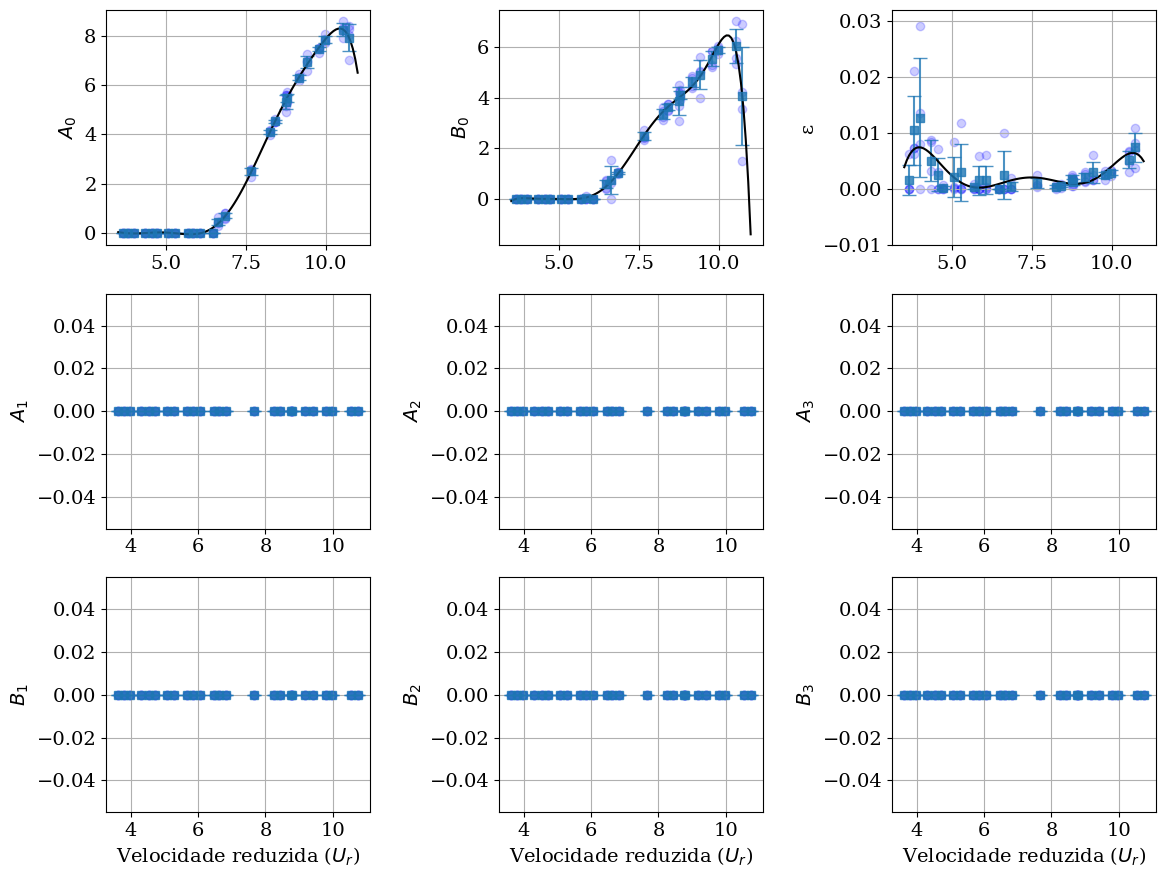

In [ ]:

plt.figure(figsize=(12, 9))
plt.subplot(3, 3, 1)
for part_idx in range(n_parts):
    plt.scatter(U, A0_parts[part_idx, :], color='blue', alpha=0.2, label=f'Parte {part_idx+1}')

plt.errorbar(U[sorted_idxs], A0_mean[sorted_idxs], yerr=A0_std[sorted_idxs], fmt='s', alpha=0.8, capsize=5)
plt.plot(U_plot, A0_plot, color='black')
#plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('$A_0$')
plt.grid(True)

plt.subplot(3, 3, 2)
for part_idx in range(n_parts):
    plt.scatter(U, B0_parts[part_idx, :], color='blue', alpha=0.2, label=f'Parte {part_idx+1}')

plt.errorbar(U[sorted_idxs], B0_mean[sorted_idxs], yerr=B0_std[sorted_idxs], fmt='s', alpha=0.8, capsize=5)
plt.plot(U_plot, B0_plot, color='black')
#plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('$B_0$')
plt.grid(True)

plt.subplot(3, 3, 3)
for part_idx in range(n_parts):
    plt.scatter(U, eps_parts[part_idx, :], color='blue', alpha=0.2, label=f'Parte {part_idx+1}')

plt.errorbar(U[sorted_idxs], eps_mean[sorted_idxs], yerr=eps_std[sorted_idxs], fmt='s', alpha = 0.8, capsize=5)
plt.plot(U_plot, eps_plot, color='black')
#plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('ε')
plt.ylim([-0.01, .032])
plt.grid(True)

plt.subplot(3, 3, 4)
for part_idx in range(n_parts):
    plt.scatter(U, A1_parts[part_idx, :], color='blue', alpha=0.2, label=f'Parte {part_idx+1}')

plt.errorbar(U[sorted_idxs], A1_mean[sorted_idxs], yerr=A1_std[sorted_idxs], fmt='s', alpha=0.8, capsize=5)
#plt.plot(U_plot, A1_plot, color='black')
#plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('$A_1$')
plt.grid(True)

plt.subplot(3, 3, 5)
for part_idx in range(n_parts):
    plt.scatter(U, A2_parts[part_idx, :], color='blue', alpha=0.2, label=f'Parte {part_idx+1}')

plt.errorbar(U[sorted_idxs], A2_mean[sorted_idxs], yerr=A2_std[sorted_idxs], fmt='s', alpha=0.8, capsize=5)
#plt.plot(U_plot, B0_plot, color='black')
#plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('$A_2$')
plt.grid(True)

plt.subplot(3, 3, 6)
for part_idx in range(n_parts):
    plt.scatter(U, A3_parts[part_idx, :], color='blue', alpha=0.2, label=f'Parte {part_idx+1}')

plt.errorbar(U[sorted_idxs], A3_mean[sorted_idxs], yerr=A3_std[sorted_idxs], fmt='s', alpha = 0.8, capsize=5)
#plt.plot(U_plot, eps_plot, color='black')
#plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('$A_3$')
#plt.ylim([-0.01, .032])
plt.grid(True)


plt.subplot(3, 3, 7)
for part_idx in range(n_parts):
    plt.scatter(U, B1_parts[part_idx, :], color='blue', alpha=0.2, label=f'Parte {part_idx+1}')

plt.errorbar(U[sorted_idxs], B1_mean[sorted_idxs], yerr=B1_std[sorted_idxs], fmt='s', alpha=0.8, capsize=5)
#plt.plot(U_plot, A1_plot, color='black')
plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('$B_1$')
plt.grid(True)

plt.subplot(3, 3, 8)
for part_idx in range(n_parts):
    plt.scatter(U, B2_parts[part_idx, :], color='blue', alpha=0.2, label=f'Parte {part_idx+1}')

plt.errorbar(U[sorted_idxs], B2_mean[sorted_idxs], yerr=B2_std[sorted_idxs], fmt='s', alpha=0.8, capsize=5)
#plt.plot(U_plot, B0_plot, color='black')`
plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('$B_2$')
plt.grid(True)

plt.subplot(3, 3, 9)
for part_idx in range(n_parts):
    plt.scatter(U, B3_parts[part_idx, :], color='blue', alpha=0.2, label=f'Parte {part_idx+1}')

plt.errorbar(U[sorted_idxs], B3_mean[sorted_idxs], yerr=B3_std[sorted_idxs], fmt='s', alpha = 0.8, capsize=5)
#plt.plot(U_plot, eps_plot, color='black')
plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('$B_3$')
#plt.ylim([-0.01, .032])
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

Ur_values = np.linspace(3.5, 11, 100)
t = T[1,:]
Y_predicted = np.zeros((len(Ur_values), len(t)))
Q_predicted = np.zeros((len(Ur_values), len(t)))
X0 = [2, 0, 0.6, 0]

for (Ur_idx, Ur) in enumerate(tqdm(Ur_values)):
    A0 = polynomial(Ur, *A0_poly)
    A1 = polynomial(Ur, *A1_poly)
    A2 = polynomial(Ur, *A2_poly)
    A3 = polynomial(Ur, *A3_poly)
    B0 = polynomial(Ur, *B0_poly)
    B1 = polynomial(Ur, *B1_poly)
    B2 = polynomial(Ur, *B2_poly)
    B3 = polynomial(Ur, *B3_poly)
    eps = polynomial(Ur, *eps_poly)

    Y_predicted[Ur_idx,:], Q_predicted[Ur_idx,:] = predict(Ur, t, X0, eps, A0, A1, A2, A3, B0, B1, B2, B3)

rms_predicted = np.array([np.sqrt(np.mean(Y_predicted[i, :]**2)) for i in range(len(Ur_values))])

rms_experimental = np.array([np.sqrt(np.mean(allY[i, :]**2)) for i in range(all_n)])

100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-1408841628.py:7: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('RMS ( ${\overline{y^2}}$ )')


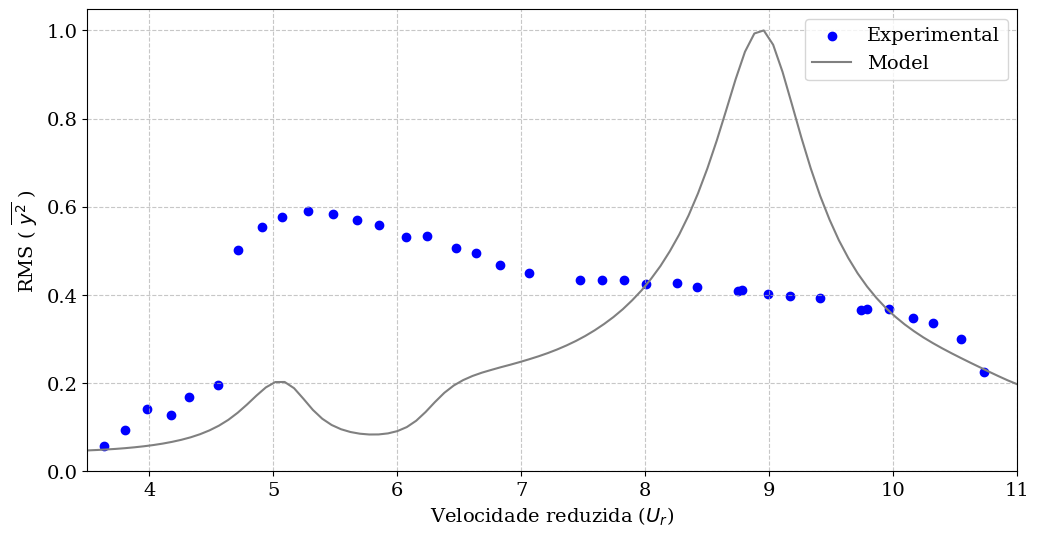

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(allU, rms_experimental, color='blue', label='Experimental')
plt.plot(Ur_values, rms_predicted, color='gray', label='Model')
#plt.ylim(0, .8)
plt.xlim(3.5, 11)
plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('RMS ( ${\overline{y^2}}$ )')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
alpha_lassos = np.arange(0.1, 2.1, 0.1)
n_alpha = len(alpha_lassos)

A0_parts = np.zeros((n_alpha, n_parts, n_train))
A1_parts = np.zeros((n_alpha, n_parts, n_train))
A2_parts = np.zeros((n_alpha, n_parts, n_train))
A3_parts = np.zeros((n_alpha, n_parts, n_train))
B0_parts = np.zeros((n_alpha, n_parts, n_train))
B1_parts = np.zeros((n_alpha, n_parts, n_train))
B2_parts = np.zeros((n_alpha, n_parts, n_train))
B3_parts = np.zeros((n_alpha, n_parts, n_train))
eps_parts = np.zeros((n_alpha, n_parts, n_train))

for alpha_idx in tqdm(range(n_alpha)):

    alpha_lasso = alpha_lassos[alpha_idx]

    for part_idx in range(n_parts):

        q_part = Q_filtered_parts[part_idx]
        q_pd_part = Q_pd_filtered_parts[part_idx]
        q_sd_part = Q_sd_filtered_parts[part_idx]
        y_sd_part = Y_sd_filtered_parts[part_idx]
        y_part = Y_filtered_parts[part_idx]
        y_pd_part = Y_pd_filtered_parts[part_idx]

        for i in range(n_train):

            clf = linear_model.Lasso(alpha=alpha_lasso, positive=True)
            q = q_part[i, :]
            q_pd = q_pd_part[i, :]
            q_sd = q_sd_part[i, :]
            y_sd = y_sd_part[i, :]
            y = y_part[i, :]
            y_pd = y_pd_part[i, :]
            S = St * U[i]
            lhs = q_sd + S**2 * q
            rhs = np.vstack((S*(1-q**2)*q_pd,
                            y_sd,
                            y_sd*np.abs(y),
                            y_sd*np.abs(y)**2,
                            y_sd*np.abs(y)**3,
                            y_pd,
                            y_pd*np.abs(y),
                            y_pd*np.abs(y)**2,
                            y_pd*np.abs(y)**3)).T

            clf.fit(rhs, lhs)

            theta=clf.coef_

            eps_parts[alpha_idx, part_idx, i] = theta[0]

            A0_parts[alpha_idx, part_idx, i] = theta[1]
            A1_parts[alpha_idx, part_idx, i] = theta[2]
            A2_parts[alpha_idx, part_idx, i] = theta[3]
            A3_parts[alpha_idx, part_idx, i] = theta[4]

            B0_parts[alpha_idx, part_idx, i] = theta[5]
            B1_parts[alpha_idx, part_idx, i] = theta[6]
            B2_parts[alpha_idx, part_idx, i] = theta[7]
            B3_parts[alpha_idx, part_idx, i] = theta[8]

A0 = np.mean(A0_parts, axis=1)
A1 = np.mean(A1_parts, axis=1)
A2 = np.mean(A2_parts, axis=1)
A3 = np.mean(A3_parts, axis=1)
B0 = np.mean(B0_parts, axis=1)
B1 = np.mean(B1_parts, axis=1)
B2 = np.mean(B2_parts, axis=1)
B3 = np.mean(B3_parts, axis=1)
eps = np.mean(eps_parts, axis=1)

degreeA = 6
degreeEps = 6

A0_poly = np.zeros((n_alpha,degreeA + 1))
A1_poly = np.zeros((n_alpha,degreeA + 1))
A2_poly = np.zeros((n_alpha,degreeA + 1))
A3_poly = np.zeros((n_alpha,degreeA + 1))
B0_poly = np.zeros((n_alpha,degreeA + 1))
B1_poly = np.zeros((n_alpha,degreeA + 1))
B2_poly = np.zeros((n_alpha,degreeA + 1))
B3_poly = np.zeros((n_alpha,degreeA + 1))
eps_poly = np.zeros((n_alpha,degreeEps + 1))


for alpha_idx in range(n_alpha):

    results = fit_train_samples(U, A0[alpha_idx], A1[alpha_idx], A2[alpha_idx], A3[alpha_idx],
                                B0[alpha_idx], B1[alpha_idx], B2[alpha_idx], B3[alpha_idx], eps[alpha_idx],
                                range(n_train), degreeA=degreeA, degreeEps=degreeEps)

    A0_poly[alpha_idx] = results['coefficients_A0']
    A1_poly[alpha_idx] = results['coefficients_A1']
    A2_poly[alpha_idx] = results['coefficients_A2']
    A3_poly[alpha_idx] = results['coefficients_A3']
    B0_poly[alpha_idx] = results['coefficients_B0']
    B1_poly[alpha_idx] = results['coefficients_B1']
    B2_poly[alpha_idx] = results['coefficients_B2']
    B3_poly[alpha_idx] = results['coefficients_B3']
    eps_poly[alpha_idx] = results['coefficients_eps']


100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


In [ ]:
#Ur_values = np.linspace(3.5, 11, 100)
t = T[1,:]
Y_predicted = np.zeros((n_alpha, len(U), len(t)))
Q_predicted = np.zeros((n_alpha, len(U), len(t)))
X0 = [2, 0, 0.6, 0]

for (Ur_idx, Ur) in enumerate(tqdm(U)):
    for alpha_idx in range(n_alpha):

        A0 = polynomial(Ur, *A0_poly[alpha_idx])
        A1 = polynomial(Ur, *A1_poly[alpha_idx])
        A2 = polynomial(Ur, *A2_poly[alpha_idx])
        A3 = polynomial(Ur, *A3_poly[alpha_idx])
        B0 = polynomial(Ur, *B0_poly[alpha_idx])
        B1 = polynomial(Ur, *B1_poly[alpha_idx])
        B2 = polynomial(Ur, *B2_poly[alpha_idx])
        B3 = polynomial(Ur, *B3_poly[alpha_idx])
        eps = polynomial(Ur, *eps_poly[alpha_idx])
        try:
            Y_predicted[alpha_idx, Ur_idx,:], Q_predicted[alpha_idx, Ur_idx,:] = predict(Ur, t, X0, eps, A0, A1, A2, A3, B0, B1, B2, B3)
        except:
            pass

100%|██████████| 25/25 [06:17<00:00, 15.10s/it]


In [ ]:
rms_predicted = np.array([[np.sqrt(np.mean(Y_predicted[alpha_idx, i, :]**2)) for i in range(len(U))] for alpha_idx in range(n_alpha)])

rms_experimental = np.array([np.sqrt(np.mean(allY[i, :]**2)) for i in range(all_n)])

sorted_idxs = np.argsort(U)


<>:12: SyntaxWarning: invalid escape sequence '\o'
<>:12: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-1885429520.py:12: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('RMS ( ${\overline{y^2}}$ )')


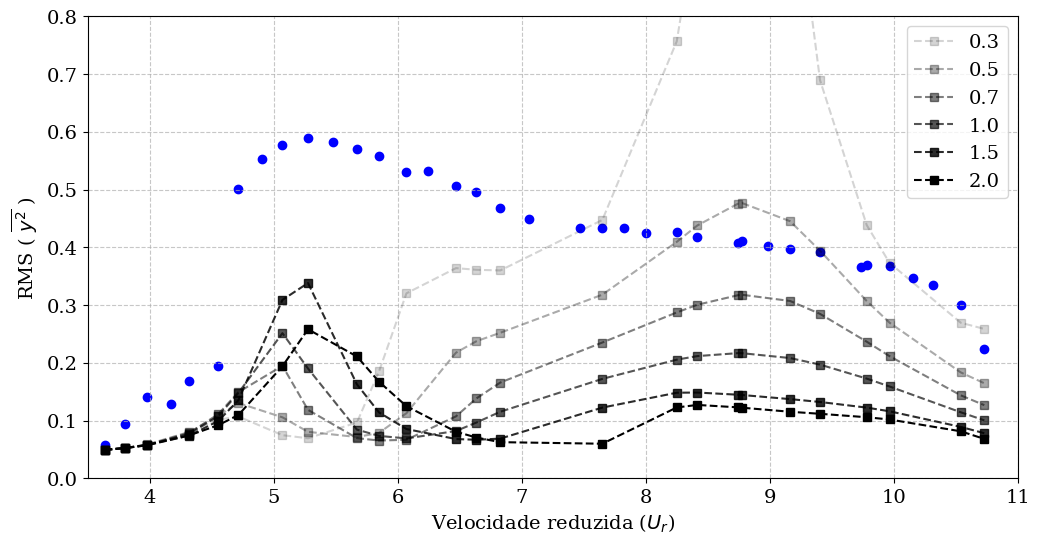

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(allU, rms_experimental, color='blue')
alpha_idxs = [2, 4, 6, 9, 14, 19]
for idx, alpha_idx in enumerate(alpha_idxs):
    plt.plot(U[sorted_idxs], rms_predicted[alpha_idx,sorted_idxs],
             linestyle= '--', marker='s', color='black',
             alpha=(idx+1)*(1/len(alpha_idxs)),
             label=f'{alpha_lassos[alpha_idx]:.1f}')
plt.ylim(0, .8)
plt.xlim(3.5, 11)
plt.xlabel('Velocidade reduzida ($U_r$)')
plt.ylabel('RMS ( ${\overline{y^2}}$ )')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
m